In [ ]:
!pip install tensorflow
!pip install stable_baselines3
!pip install gym
!pip install gym-anytrading


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C,TD3,DQN

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data=pd.read_csv("NVDA.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


In [ ]:
data['Date']=pd.to_datetime(data['Date'],format='%d-%m-%Y')
data.dtypes

ValueError: time data "2000-01-03" doesn't match format "%d-%m-%Y", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
data.set_index('Date', inplace=True)
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400


In [ ]:
window_size = 7
start_index = window_size
train_end_index =int(len(data)*0.8)
test_end_index=len(data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make(
    'stocks-v0',
    df=data,
    window_size=window_size,
    frame_bound=(start_index,train_end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (7, 2), float32)


In [ ]:
env.reset(seed=7)
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=100000)

action_stats: {<Actions.Sell: 0>: 1042, <Actions.Buy: 1>: 174}
info: {'total_reward': -26.637596130371094, 'total_profit': 0.33830961836684514, 'position': <Positions.Short: 0>}


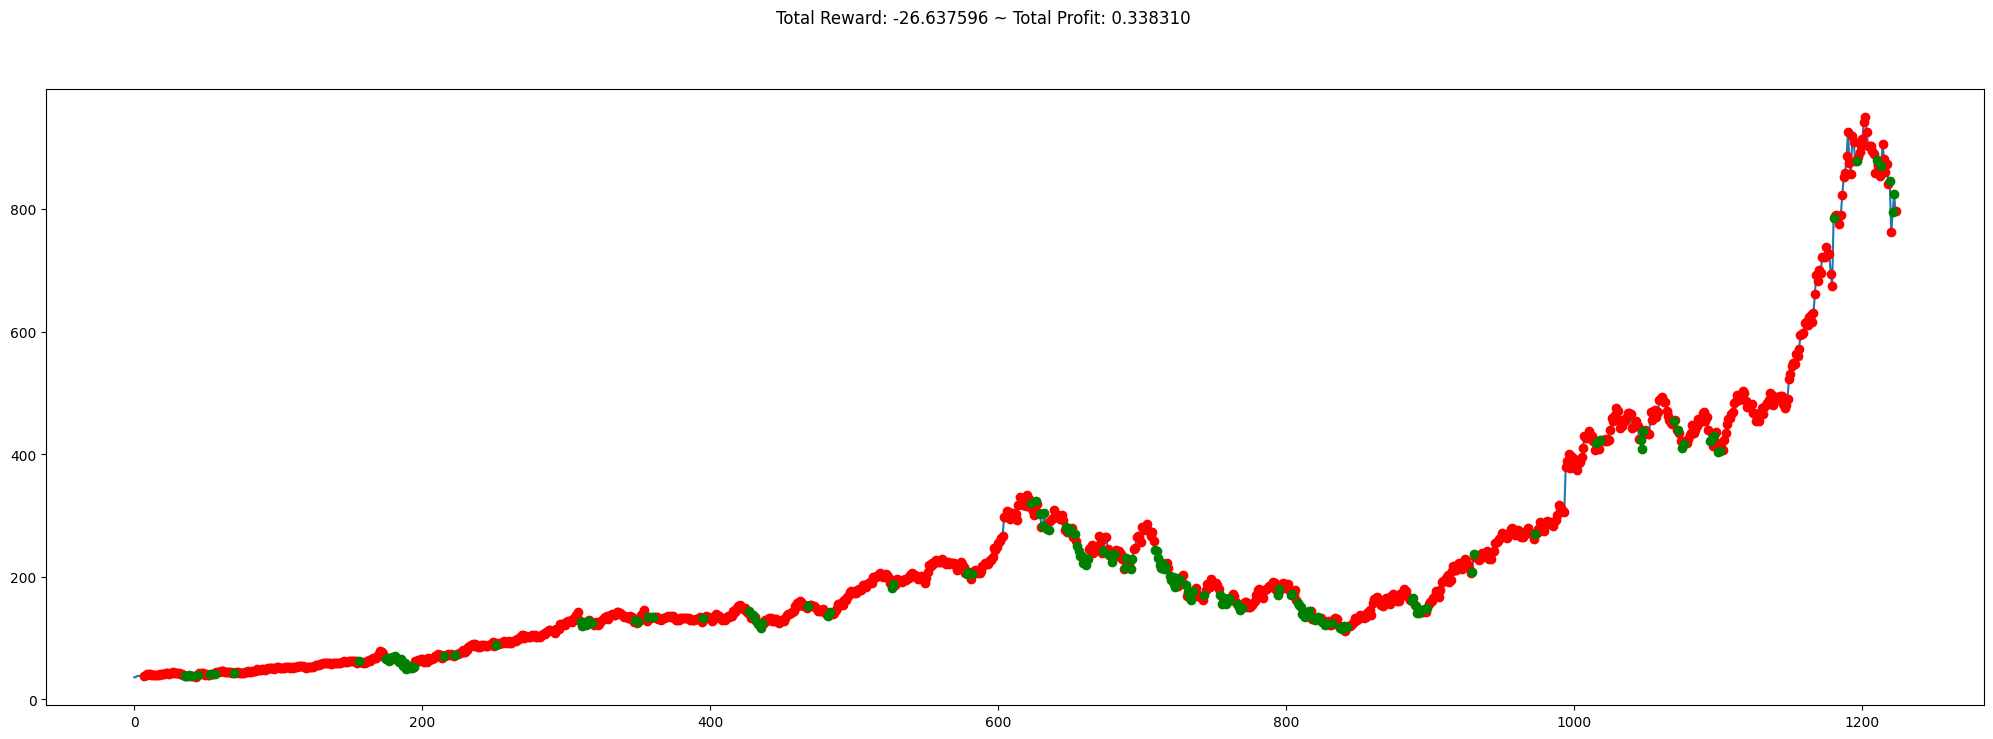

In [ ]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
test_env = gym.make(
    'stocks-v0',
    df=data.iloc[train_end_index:],
    window_size=window_size,
    frame_bound=(window_size,len(data.iloc[train_end_index:]))
)
observation, info = test_env.reset(seed=7)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)
plt.figure(figsize=(25,8))
plt.cla()
test_env.unwrapped.render_all()
plt.show()

In [ ]:
env.reset(seed=7)
print(env.action_space)
model_2 =PPO('MlpPolicy', env, verbose=0)
model_2.learn(total_timesteps=100000)

Discrete(2)


action_stats: {<Actions.Sell: 0>: 807, <Actions.Buy: 1>: 409}
info: {'total_reward': 105.96749496459961, 'total_profit': 0.07167917680459142, 'position': <Positions.Long: 1>}


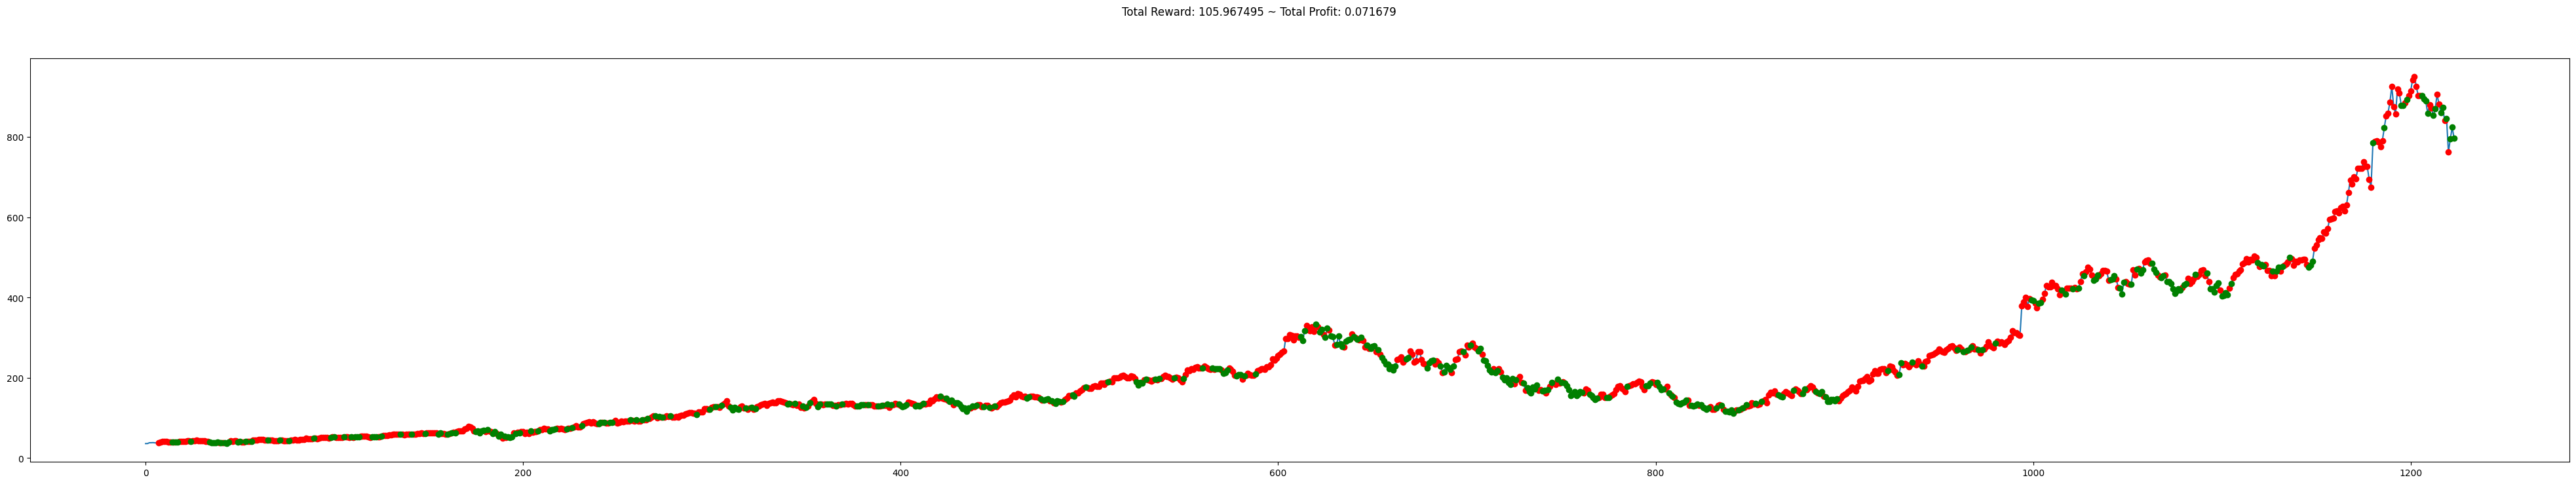

In [ ]:

action_stats = {Actions.Sell: 0, Actions.Buy: 0}
test_env = gym.make(
    'stocks-v0',
    df=data.iloc[train_end_index:],
    window_size=window_size,
    frame_bound=(window_size,len(data.iloc[train_end_index:]))
)
observation, info = test_env.reset(seed=7)

while True:
    # action = env.action_space.sample()
    action, _states = model_2.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)
plt.figure(figsize=(50,8))
plt.cla()
test_env.unwrapped.render_all()
plt.show()

In [ ]:
env.reset(seed=7)
print(env.action_space)
model_3 =DQN('MlpPolicy', env, verbose=0)
model_3.learn(total_timesteps=100000)


Discrete(2)


action_stats: {<Actions.Sell: 0>: 1128, <Actions.Buy: 1>: 88}
info: {'total_reward': -28.715072631835938, 'total_profit': 0.20573314333459072, 'position': <Positions.Short: 0>}


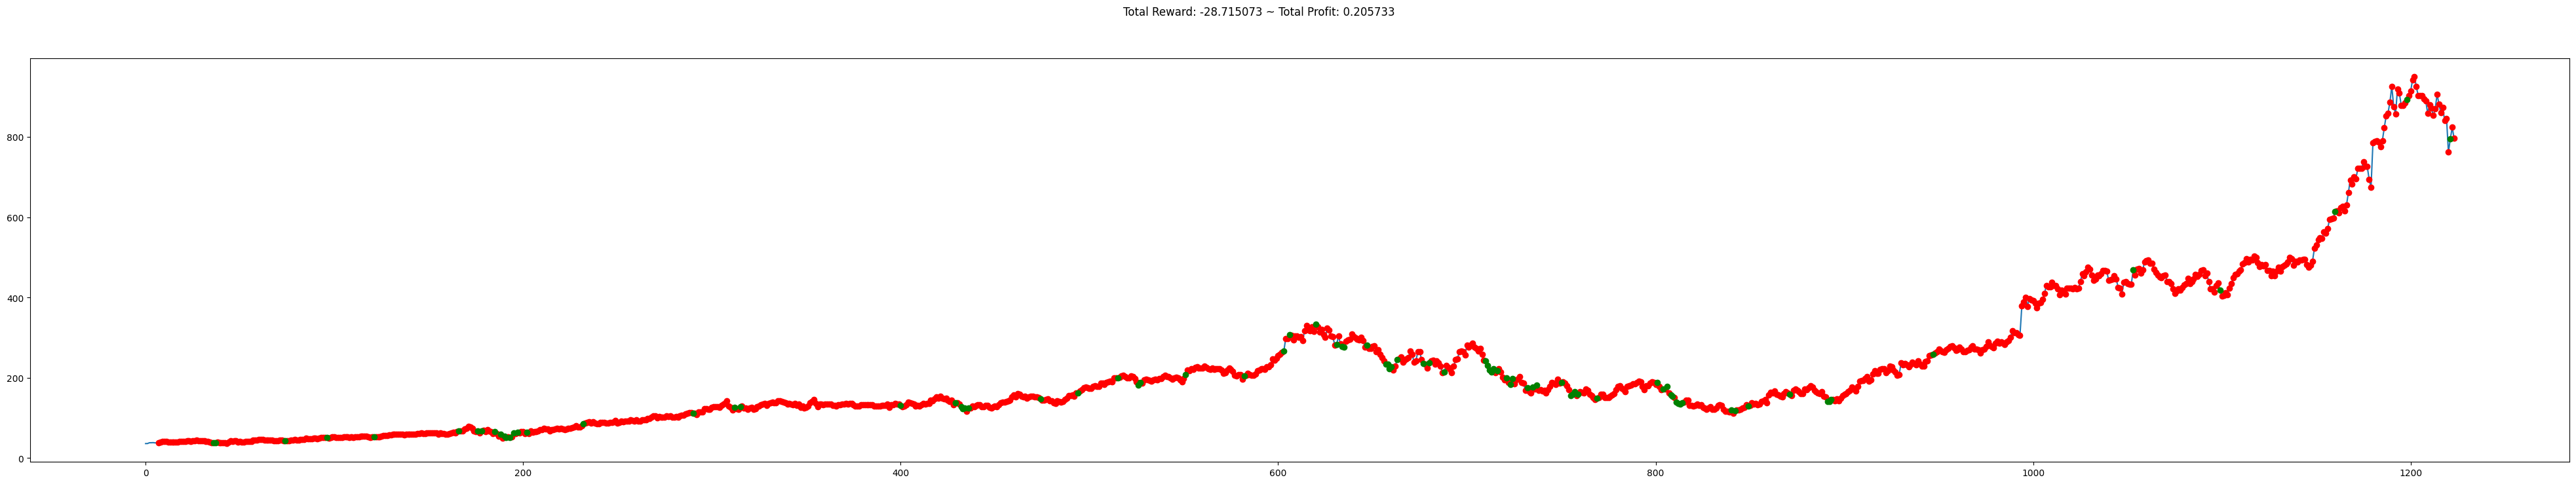

In [ ]:

action_stats = {Actions.Sell: 0, Actions.Buy: 0}
test_env = gym.make(
    'stocks-v0',
    df=data.iloc[train_end_index:],
    window_size=window_size,
    frame_bound=(window_size,len(data.iloc[train_end_index:]))
)
observation, info = test_env.reset(seed=7)

while True:
    # action = env.action_space.sample()
    action, _states = model_3.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)
plt.figure(figsize=(50,8))
plt.cla()
test_env.unwrapped.render_all()
plt.show()